In [1]:
!pip install pymysql

     |████████████████████████████████| 43 kB 2.4 MB/s 


In [4]:
import numpy as np
import pandas as pd
import pymysql
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# # 데이터 불러오기
---

In [5]:
conn = pymysql.connect(host='34.64.224.44', user='root', password='A412GBVSDsawe%$we', db='smart_factory')
sql_state='select * from `rawdata`'
df = pd.read_sql_query(sql_state, conn)
df = df[['SOLDDATE', 'CUSTID', 'PRODNAME', 'QUANT']]

conn = pymysql.connect(host='34.64.224.44', user='root', password='A412GBVSDsawe%$we', db='smart_factory')
sql_state='select * from `weather_day`'
df_weather = pd.read_sql_query(sql_state, conn)
df_weather = df_weather.groupby('SOLDDATE').mean()

conn = pymysql.connect(host='34.64.224.44', user='root', password='A412GBVSDsawe%$we', db='smart_factory')
sql_state='select * from `building_construction_temp`'
df_construction = pd.read_sql_query(sql_state, conn)

conn = pymysql.connect(host='34.64.224.44', user='root', password='A412GBVSDsawe%$we', db='smart_factory')
sql_state='select * from `building_permission_temp`'
df_permission = pd.read_sql_query(sql_state, conn)


display(df, df_weather, df_construction, df_permission)

,SOLDDATE,CUSTID,PRODNAME,QUANT
0,2017-01-01,2005500,PEMA-HR1500,5600.0
1,2017-01-01,2003800,PEMA-HR1500,5600.0
2,2017-01-01,2004200,PEMA-HR1000,6100.0
3,2017-01-01,2002100,PEMA-HR1000,6100.0
4,2017-01-01,2007500,PEMA-SR2000,4500.0
...,...,...,...,...
55537,2022-04-24,2006900,PEMA-SR2000,3700.0
55538,2022-04-24,2003400,PEMA-HR1500,4200.0
55539,2022-04-24,2003000,PEMA-HR1000,5300.0
55540,2022-04-24,2007400,PEMA-SR2000,3700.0


,TEMP,HUM,RAIN,SNOW
SOLDDATE,,,,
2014-01-01,4.49375,56.50000,0.00625,0.0
2014-01-02,2.53125,49.54375,0.00000,0.0
2014-01-03,2.52500,55.35625,0.00000,0.0
2014-01-04,1.36875,59.59375,0.00000,0.0
2014-01-05,0.47500,60.39375,0.00000,0.0
...,...,...,...,...
2022-04-28,16.41875,55.34375,0.00625,0.0
2022-04-29,12.37500,73.96875,14.30625,0.0
2022-04-30,13.03750,67.38750,0.00000,0.0


,연도,월,총계,주거용,상업용,농수산용,공업용,공공용,교육사회용,기타
0,2002,1,4606573.0,1196476.0,1800731.0,105471.0,988765.0,6810.0,305599.0,202721.0
1,2002,2,6469007.0,2126741.0,2012309.0,148971.0,853979.0,58895.0,481927.0,786185.0
2,2002,3,9791144.0,4116061.0,2873704.0,253077.0,1327957.0,43854.0,595916.0,580575.0
3,2002,4,7502278.0,2492311.0,2738559.0,299022.0,929831.0,66600.0,619158.0,356797.0
4,2002,5,8020439.0,2980978.0,2468974.0,552414.0,1022873.0,29459.0,517058.0,448683.0
...,...,...,...,...,...,...,...,...,...,...
238,2021,11,11543841.0,3598611.0,3342337.0,599388.0,1533741.0,58619.0,630203.0,1780942.0
239,2021,12,14224754.0,5457308.0,3474508.0,481155.0,1242796.0,130735.0,1044632.0,2393620.0
240,2022,1,7309396.0,1699745.0,2422706.0,290212.0,1013386.0,125342.0,423769.0,1334236.0
241,2022,2,7294384.0,2480321.0,1885971.0,295254.0,813621.0,75865.0,534801.0,1208551.0


,연도,월,총계,주거용,상업용,농수산용,공업용,공공용,교육사회용,기타
0,2002,1,9344374.0,3788023.0,3441822.0,207811.0,1246418.0,30748.0,438431.0,191121.0
1,2002,2,8294507.0,3466368.0,2899801.0,172183.0,1003784.0,61736.0,493217.0,197418.0
2,2002,3,13960644.0,6329311.0,5068121.0,246638.0,1257046.0,42940.0,627706.0,388882.0
3,2002,4,13486345.0,5315253.0,5223113.0,301994.0,1607455.0,30898.0,628208.0,379424.0
4,2002,5,14590626.0,5213790.0,6006266.0,329304.0,1801005.0,39754.0,738477.0,462030.0
...,...,...,...,...,...,...,...,...,...,...
238,2021,11,14483042.0,4793022.0,4460134.0,477336.0,1378314.0,136506.0,879114.0,2358616.0
239,2021,12,19169150.0,5830884.0,5691514.0,464124.0,1579046.0,67882.0,1263720.0,4271980.0
240,2022,1,13736304.0,5027420.0,3328383.0,349763.0,1861404.0,10173.0,767553.0,2391608.0
241,2022,2,11862344.0,3341809.0,3106917.0,287273.0,1412082.0,46456.0,899657.0,2768150.0


# # 생산계획에 사용할 변수 시계열 예측
---

## # 시계열 예측 사용자 함수
---

In [270]:
# 데이터 정규화 함수
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        series = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array)
    else:
        scaler = None

    return training_data, scaler


# 훈련데이터와 예측용 데이터 뽑는 함수 (many-to-many)
def make_dataset_many(training_data, t, h=0):
    
    X_train = []
    X_test = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t +1:i + 1])
        y_train.append(training_data[i+1 : i+1+h])

    for i in range(h):
        X_test.append(training_data[-t -h + i: -h + i])
        if -h + i + 1 == 0:
            X_test.append(training_data[-t-h + i + 1:])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test[-1].reshape(1, t, training_data.shape[1]))

    return X_train, y_train, X_test


# 훈련데이터와 예측용 데이터 뽑기 (many-to-one)
# def make_dataset_one(training_data, t, h=0):
    
#     X_train = []
#     X_test = []
#     y_train = []
#     for i in range(t, len(training_data)-h):
#         X_train.append(training_data[i-t +1:i + 1])
#         y_train.append(training_data[i+h])

#     for i in range(h):
#         X_test.append(training_data[-t -h + i: -h + i])
#         if -h + i + 1 == 0:
#             X_test.append(training_data[-t-h + i + 1:])

    
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)[:, 0].reshape(-1, 1)

#     X_test = np.array(X_test[1:])

#     return X_train, y_train, X_test


# 훈련데이터와 예측용 데이터 뽑기 (many-to-one) - 수정
def make_dataset_one(training_data, t, h=0, p=0):
    
    X_train_temp = []
    X_test_temp = []
    y_train_temp = []
    for i in range(t, len(training_data)-h):
        X_train_temp.append(training_data[i-t +1:i + 1])
        y_train_temp.append(training_data[i+h])
    
    X_train = np.array(X_train_temp)
    y_train = np.array(y_train_temp)[:, 0].reshape(-1, 1)

    X_test = np.array(X_train_temp)[-p:-p+int(p/2) + 2]

    return X_train, y_train, X_test


# 훈련, 테스트 데이터 나누기
# X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)


# pred 값 정규화를 되돌려서 뽑는 함수
def get_pred(X_test, model):
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds)

    return preds.reshape(-1, 1)


# 평가지표 사용자 함수
def get_score(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared = False)
    r2 = r2_score(y_true, y_pred)

    print('mae :', mae)
    print('mse :', mse)
    print('rmse :', rmse)
    print('r2_score :', r2)

## # GRU 사용
---

### # 온도
---

In [245]:
from tensorflow.keras.losses import Huber

df_weather[['TEMP']].info()

training_data, scaler = preprocess(df_weather[['TEMP']].values)
X_train, y_train, X_test = make_dataset_one(training_data, t = 365, h = 1, p = 365)
# X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)

unit = 128
output = 1

# The GRU architecture
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=unit, return_sequences=True, activation='tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
    
# # Third GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))

# Fourth GRU layer
model.add(GRU(units=unit, activation='tanh'))

# The output layer
model.add(Dense(units=output))

# Compiling the RNN
model.compile(optimizer='adam',
              loss=Huber(),
              metrics = ['mae'])

early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Fitting to the training set
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    validation_split = 0.2,
                    batch_size= 25,
                    # callbacks = [early_stop],
                    verbose=1)

# 예측값 
# preds = get_pred(X_test_temp, model)
preds = get_pred(X_test, model)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3044 entries, 2014-01-01 to 2022-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    3044 non-null   float64
dtypes: float64(1)
memory usage: 112.1 KB
Epoch 1/50
86/86 [==============================] - 12s 75ms/step - loss: 0.0083 - mae: 0.0852 - val_loss: 0.0035 - val_mae: 0.0667
Epoch 2/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0025 - mae: 0.0555 - val_loss: 0.0032 - val_mae: 0.0628
Epoch 3/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0024 - mae: 0.0542 - val_loss: 0.0031 - val_mae: 0.0583
Epoch 4/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0021 - mae: 0.0504 - val_loss: 0.0025 - val_mae: 0.0526
Epoch 5/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0020 - mae: 0.0494 - val_loss: 0.0024 - val_mae: 0.0534
Epoch 6/50
86/86 [==============================] - 5s 61ms/step - 

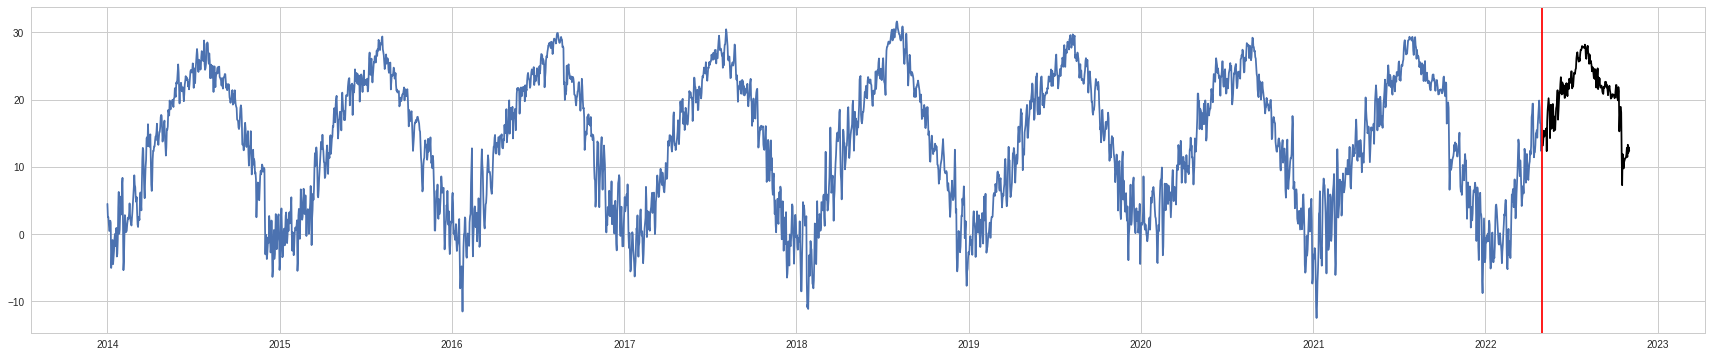

mae : 0.9149885872135993
mse : 0.9966665351332875
rmse : 0.9983318762482182
r2_score : 0.9574789722191643


In [248]:
# 시각화
n_future = X_test.shape[0]
forecast_period_dates = pd.date_range('2022-05-03', periods=n_future, freq='1d').tolist()
# forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
df_pred['QUANT'] = preds

import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(30,6))
plt.plot(df_weather['TEMP'])
plt.plot(df_pred.set_index('SOLDDATE'), color = 'black')
plt.axvline(df_weather.index[-1], color='r')
plt.show()

# 모델 평가
d = -1
get_score(df_weather['TEMP'][-365+d:-X_test.shape[0] + (X_test.shape[0] - (365-X_test.shape[0]))+d], preds)

In [ ]:
# 모델 저장

dir = '/content/drive/MyDrive/workspace/cakd5/2차_project/작업물/생산 계획 모델/'
model.save(dir + 'weather_temp.h5')

#### # 온도 모델 이용하여 미래 온도 데이터프레임 생성
---
- 사용 안함

In [ ]:
# model_temp = load_model('/content/drive/MyDrive/workspace/cakd5/2차_project/작업물/생산 계획 모델/weather_temp.h5')

# df_temp = pd.DataFrame()
# for i in df_weather['REGION_U'].unique():
#     df_weather1 = df_weather.loc[df_weather['REGION_U'] == i].set_index('SOLDDATE')[['TEMP']]
#     df_weather1

#     training_data, scaler = preprocess(df_weather1.values)
#     X_train, y_train, X_test = make_dataset_many(training_data, t = 365, h = 93)
#     X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)
    
#     preds_future = get_pred(X_test, model_temp)

#     n_future = 93
#     forecast_period_dates = pd.date_range('2022-04-25', periods=n_future, freq='1d').tolist()
    
#     df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
#     df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
#     df_pred['QUANT'] = preds_future
#     df_pred['REGION_U'] = i

#     df_temp = pd.concat((df_temp, df_pred), axis = 0)

# df_temp

,SOLDDATE,QUANT,REGION_U
0,2022-04-25,17.877977,서울
1,2022-04-26,16.640806,서울
2,2022-04-27,16.643812,서울
3,2022-04-28,16.844410,서울
4,2022-04-29,17.195381,서울
...,...,...,...
88,2022-07-22,27.045061,강원도
89,2022-07-23,27.777540,강원도
90,2022-07-24,26.860243,강원도
91,2022-07-25,26.738665,강원도


### # 습도
---

In [257]:
from tensorflow.keras.losses import Huber

df_weather[['HUM']].info()

training_data, scaler = preprocess(df_weather[['HUM']].values)
X_train, y_train, X_test = make_dataset_one(training_data, t = 365, h = 1, p = 365)
# X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)

unit = 256
output = 1

# The GRU architecture
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=unit, return_sequences=True, activation='tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
    
# # Third GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.1))

# Fourth GRU layer
model.add(GRU(units=unit, activation='tanh'))

# The output layer
model.add(Dense(units=output))

# Compiling the RNN
model.compile(optimizer='adam',
              loss=Huber(),
              metrics = ['mae'])

early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Fitting to the training set
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    validation_split = 0.2,
                    batch_size= 32,
                    # callbacks = [early_stop],
                    verbose=1)

# 예측값 
preds = get_pred(X_test, model)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3044 entries, 2014-01-01 to 2022-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUM     3044 non-null   float64
dtypes: float64(1)
memory usage: 112.1 KB
Epoch 1/50
67/67 [==============================] - 13s 103ms/step - loss: 0.0233 - mae: 0.1651 - val_loss: 0.0128 - val_mae: 0.1286
Epoch 2/50
67/67 [==============================] - 6s 85ms/step - loss: 0.0133 - mae: 0.1295 - val_loss: 0.0122 - val_mae: 0.1249
Epoch 3/50
67/67 [==============================] - 6s 86ms/step - loss: 0.0121 - mae: 0.1221 - val_loss: 0.0100 - val_mae: 0.1094
Epoch 4/50
67/67 [==============================] - 6s 86ms/step - loss: 0.0107 - mae: 0.1114 - val_loss: 0.0094 - val_mae: 0.1053
Epoch 5/50
67/67 [==============================] - 6s 87ms/step - loss: 0.0104 - mae: 0.1095 - val_loss: 0.0094 - val_mae: 0.1044
Epoch 6/50
67/67 [==============================] - 6s 87ms/step -

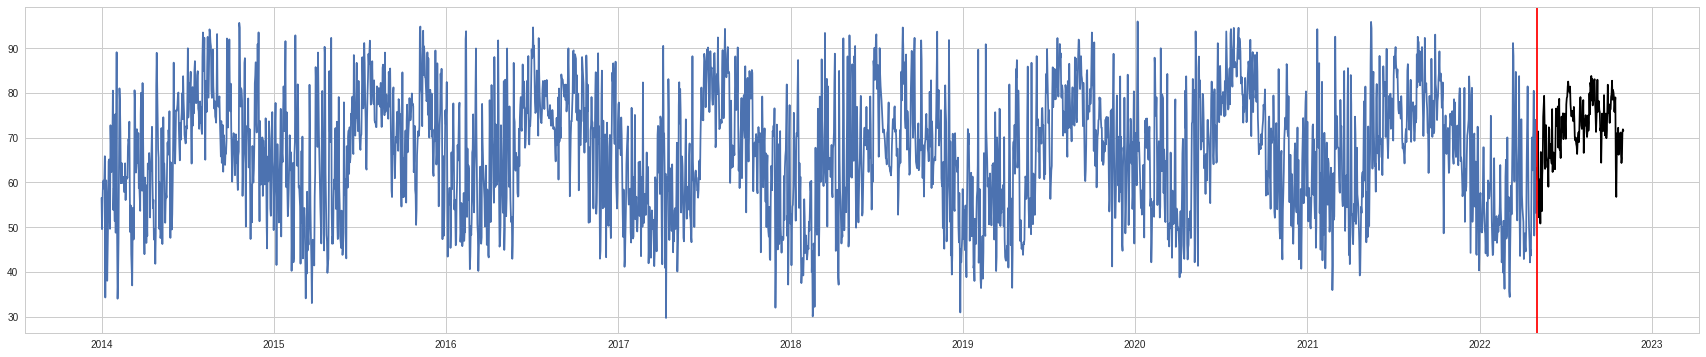

mae : 3.496082480057427
mse : 22.54810025211169
rmse : 4.748483995141154
r2_score : 0.7338134818720125


In [258]:
b# 시각화
n_future = X_test.shape[0]
forecast_period_dates = pd.date_range('2022-05-03', periods=n_future, freq='1d').tolist()
# forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
df_pred['QUANT'] = preds

import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(30,6))
plt.plot(df_weather['HUM'])
plt.plot(df_pred.set_index('SOLDDATE'), color = 'black')
plt.axvline(df_weather.index[-1], color='r')
plt.show()

# 모델 평가
d = -1
get_score(df_weather['HUM'].values[-365+d:-X_test.shape[0] + (X_test.shape[0] - (365-X_test.shape[0]))+d], preds)

In [ ]:
# 모델 저장

dir = '/content/drive/MyDrive/workspace/cakd5/2차_project/작업물/생산 계획 모델/'
model.save(dir + 'weather_hum.h5')

### # 강수량
---

In [ ]:
from tensorflow.keras.losses import Huber

df_weather[['RAIN']].info()

training_data, scaler = preprocess(df_weather[['RAIN']].values)
X_train, y_train, X_test = make_dataset_one(training_data, t = 180, h = 1, p = 365)
# X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)

unit = 256
output = 1

# The GRU architecture
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=unit, return_sequences=True, activation='tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
    
# # Third GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))

# Fourth GRU layer
model.add(GRU(units=unit, activation='tanh'))

# The output layer
model.add(Dense(units=output))

# Compiling the RNN
model.compile(optimizer='adam',
              loss=Huber(),
              metrics = ['mae'])

early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Fitting to the training set
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    validation_split = 0.2,
                    batch_size= 25,
                    # callbacks = [early_stop],
                    verbose=1)

# 예측값 
preds = get_pred(X_test, model)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3042 entries, 2014-01-01 to 2022-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RAIN    3042 non-null   float64
dtypes: float64(1)
memory usage: 47.5 KB
Epoch 1/50
86/86 [==============================] - 16s 113ms/step - loss: 0.0055 - mae: 0.0573 - val_loss: 0.0033 - val_mae: 0.0494
Epoch 2/50
86/86 [==============================] - 8s 99ms/step - loss: 0.0051 - mae: 0.0539 - val_loss: 0.0033 - val_mae: 0.0387
Epoch 3/50
86/86 [==============================] - 8s 99ms/step - loss: 0.0050 - mae: 0.0552 - val_loss: 0.0037 - val_mae: 0.0602
Epoch 4/50
86/86 [==============================] - 8s 99ms/step - loss: 0.0050 - mae: 0.0530 - val_loss: 0.0035 - val_mae: 0.0481
Epoch 5/50
86/86 [==============================] - 8s 99ms/step - loss: 0.0050 - mae: 0.0527 - val_loss: 0.0034 - val_mae: 0.0497
Epoch 6/50
86/86 [==============================] - 8s 99ms/step - 

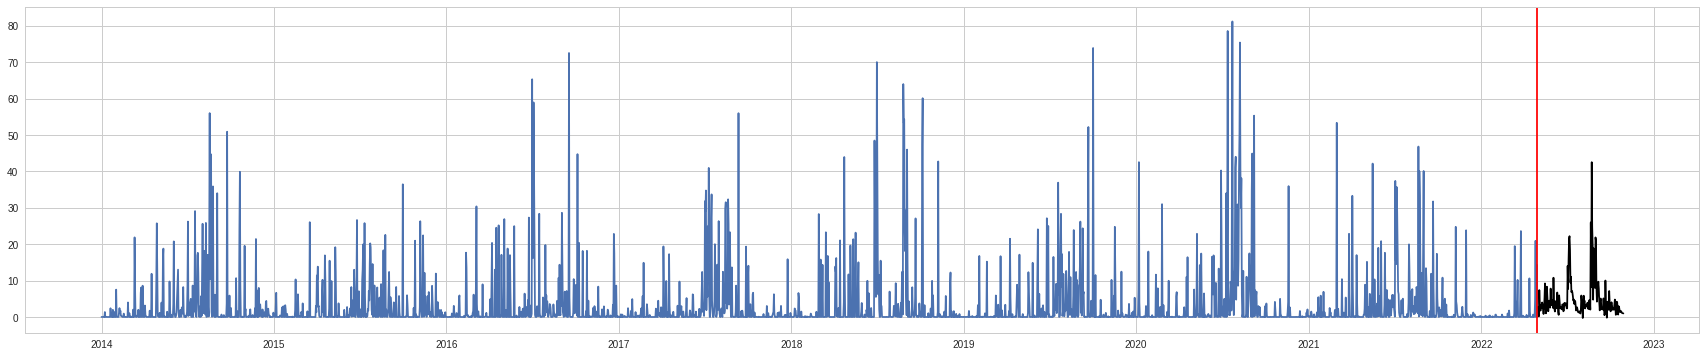

mae : 3.3255016951115577
mse : 29.962732697473825
rmse : 5.473822494151032
r2_score : 0.621248116956054


In [ ]:
# 시각화
n_future = X_test.shape[0]
forecast_period_dates = pd.date_range('2022-05-03', periods=n_future, freq='1d').tolist()
# forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
df_pred['QUANT'] = preds

import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(30,6))
plt.plot(df_weather['RAIN'])
plt.plot(df_pred.set_index('SOLDDATE'), color = 'black')
plt.axvline(df_weather.index[-1], color='r')
plt.show()

# 모델 평가
get_score(df_weather['RAIN'].values[-365:-X_test.shape[0] + (X_test.shape[0] - (365-X_test.shape[0]))], preds)

In [ ]:
# 모델 저장

dir = '/content/drive/MyDrive/workspace/cakd5/2차_project/작업물/생산 계획 모델/'
model.save(dir + 'weather_rain.h5')

### # 신적설량
---

In [229]:
from tensorflow.keras.losses import Huber

df_weather[['SNOW']].info()

training_data, scaler = preprocess(df_weather[['SNOW']].values)
X_train, y_train, X_test = make_dataset_one(training_data, t = 365, h = 1, p = 730)
# X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)

unit = 128
output = 1

# The GRU architecture
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=unit, return_sequences=True, activation='tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
    
# # Third GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))

# Fourth GRU layer
model.add(GRU(units=unit, activation='tanh'))

# The output layer
model.add(Dense(units=output))

# Compiling the RNN
model.compile(optimizer='adam',
              loss=Huber(),
              metrics = ['mae'])

early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Fitting to the training set
history = model.fit(X_train,
                    y_train,
                    epochs = 60,
                    validation_split = 0.2,
                    batch_size= 25,
                    # callbacks = [early_stop],
                    verbose=1)

# 예측값 
preds = get_pred(X_test, model)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3044 entries, 2014-01-01 to 2022-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SNOW    3044 non-null   float64
dtypes: float64(1)
memory usage: 112.1 KB
Epoch 1/60
86/86 [==============================] - 12s 77ms/step - loss: 0.0016 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0185
Epoch 2/60
86/86 [==============================] - 5s 60ms/step - loss: 0.0016 - mae: 0.0158 - val_loss: 0.0017 - val_mae: 0.0174
Epoch 3/60
86/86 [==============================] - 5s 61ms/step - loss: 0.0015 - mae: 0.0165 - val_loss: 0.0019 - val_mae: 0.0266
Epoch 4/60
86/86 [==============================] - 5s 61ms/step - loss: 0.0016 - mae: 0.0177 - val_loss: 0.0018 - val_mae: 0.0120
Epoch 5/60
86/86 [==============================] - 5s 61ms/step - loss: 0.0015 - mae: 0.0159 - val_loss: 0.0016 - val_mae: 0.0187
Epoch 6/60
86/86 [==============================] - 5s 61ms/step - 

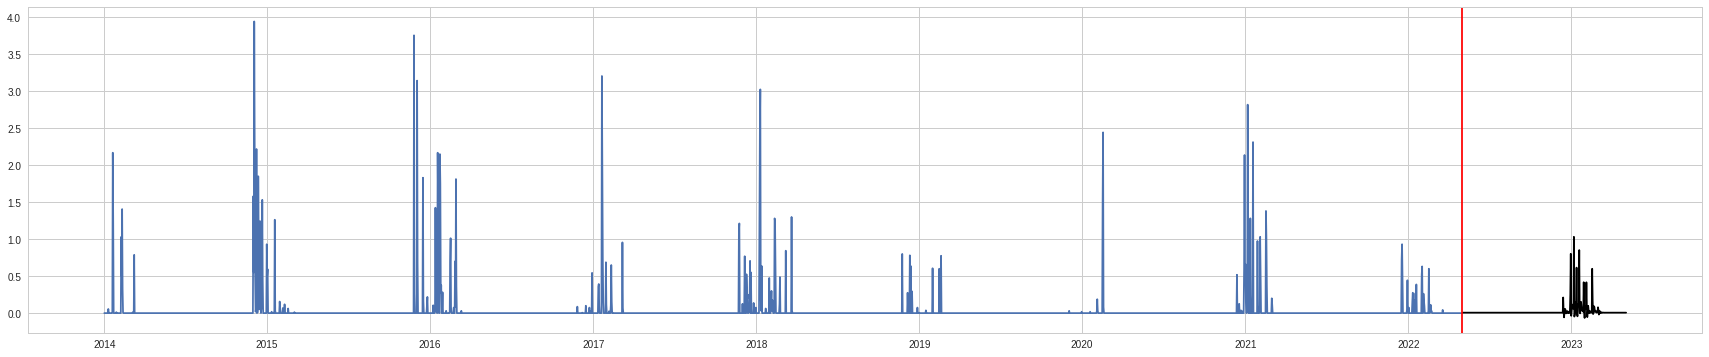

mae : 0.044653891040358905
mse : 0.034662271513891646
rmse : 0.18617806399759249
r2_score : 0.5289983861261276


In [237]:
# 시각화
n_future = X_test.shape[0]
forecast_period_dates = pd.date_range('2022-05-03', periods=n_future, freq='1d').tolist()
# forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
df_pred['QUANT'] = preds

import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(30,6))
plt.plot(df_weather['SNOW'])
plt.plot(df_pred.set_index('SOLDDATE'), color = 'black')
plt.axvline(df_weather.index[-1], color='r')
plt.show()

# 모델 평가
get_score(df_weather['SNOW'].values[-731:-X_test.shape[0]+3], preds)
# get_score(df_weather['RAIN'].values[-365:-X_test.shape[0] + (X_test.shape[0] - (365-X_test.shape[0]))], preds)

In [ ]:
# 모델 저장

dir = '/content/drive/MyDrive/workspace/cakd5/2차_project/작업물/생산 계획 모델/'
model.save(dir + 'weather_snow.h5')

### # 건축착공면적
---

In [306]:
from tensorflow.keras.losses import Huber

training_data, scaler = preprocess(df_construction[['총계']].values)
X_train, y_train, X_test = make_dataset_one(training_data, t = 12, h = 1, p = 12)

unit = 64
output = 1

# The LSTM architecture
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(LSTM(units=unit, return_sequences=True, activation='tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
    
# # Third LSTM layer
# model.add(LSTM(units=unit, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.1))

# Fourth LSTM layer
model.add(LSTM(units=unit, activation='tanh'))

# The output layer
model.add(Dense(units=output))

# Compiling the RNN
model.compile(optimizer='adam',
              loss=Huber(),
              metrics = ['mae'])

early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Fitting to the training set
history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    validation_split = 0.2,
                    batch_size= 10,
                    # callbacks = [early_stop],
                    verbose=1)

# 예측값 
# preds = get_pred(X_test_temp, model)
preds = get_pred(X_test, model)

Epoch 1/10
19/19 [==============================] - 7s 68ms/step - loss: 0.0267 - mae: 0.1821 - val_loss: 0.0120 - val_mae: 0.1290
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0104 - mae: 0.1110 - val_loss: 0.0080 - val_mae: 0.1056
Epoch 3/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0095 - mae: 0.1055 - val_loss: 0.0079 - val_mae: 0.1015
Epoch 4/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0095 - mae: 0.1052 - val_loss: 0.0076 - val_mae: 0.1015
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0088 - mae: 0.1014 - val_loss: 0.0083 - val_mae: 0.1046
Epoch 6/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0091 - mae: 0.1030 - val_loss: 0.0080 - val_mae: 0.1048
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0110 - mae: 0.1138 - val_loss: 0.0102 - val_mae: 0.1184
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0096 - mae

In [307]:
preds

array([[10944656.],
       [10991390.],
       [11034586.],
       [11163083.],
       [11256895.],
       [11489990.],
       [11506086.],
       [11651999.]], dtype=float32)

mae : 721105.25
mse : 1094724221407.25
rmse : 1046290.6964162732
r2_score : -0.10708560341168782


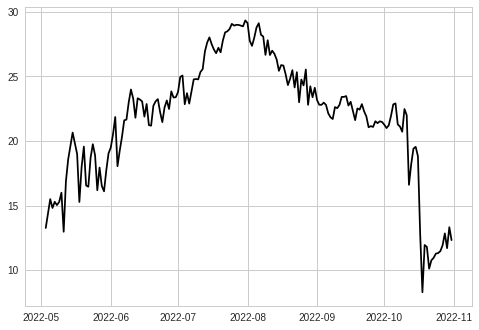

In [308]:
# 예측값 
# preds = get_pred(X_test_temp[-1].reshape(1, -1, 1), model)
# preds_future = get_pred(X_test, model)


# # 시각화
# n_future = 3
# forecast_period_dates = pd.date_range('2022-03-01', periods=n_future, freq='1m').tolist()
# # forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

# df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
# df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
# df_pred['QUANT'] = preds_future

# import matplotlib.pyplot as plt
# plt.style.use(['seaborn-whitegrid'])
# plt.figure(figsize=(30,6))
# plt.plot(df_construction['총계'])
plt.plot(df_pred.set_index('SOLDDATE'), color = 'black')
# plt.axvline(df_weather1.index[-1], color='r')
# plt.show()


# 모델 평가
get_score(df_construction['총계'][-12:-4], preds)

In [304]:
df_construction[-12:]

,연도,월,총계,주거용,상업용,농수산용,공업용,공공용,교육사회용,기타
231,2021,4,12006327.0,4109848.0,3041412.0,876882.0,1699202.0,15057.0,578033.0,1685893.0
232,2021,5,12571458.0,3239832.0,4789394.0,671651.0,1326080.0,95976.0,985239.0,1463286.0
233,2021,6,10969332.0,3675962.0,3199932.0,612984.0,1565478.0,61579.0,599303.0,1254094.0
234,2021,7,10615761.0,3511341.0,3151322.0,545319.0,1225227.0,60146.0,658470.0,1463936.0
235,2021,8,9072363.0,3192223.0,2882205.0,471486.0,859425.0,53203.0,475405.0,1138416.0
236,2021,9,11496673.0,4348635.0,3134789.0,431308.0,1163764.0,59917.0,401356.0,1956904.0
237,2021,10,11721240.0,4316315.0,3006075.0,404530.0,1834724.0,29489.0,643421.0,1486686.0
238,2021,11,11543841.0,3598611.0,3342337.0,599388.0,1533741.0,58619.0,630203.0,1780942.0
239,2021,12,14224754.0,5457308.0,3474508.0,481155.0,1242796.0,130735.0,1044632.0,2393620.0
240,2022,1,7309396.0,1699745.0,2422706.0,290212.0,1013386.0,125342.0,423769.0,1334236.0


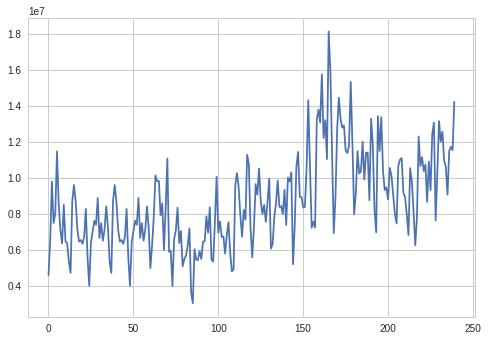

In [ ]:
plt.plot(df_construction['총계'])

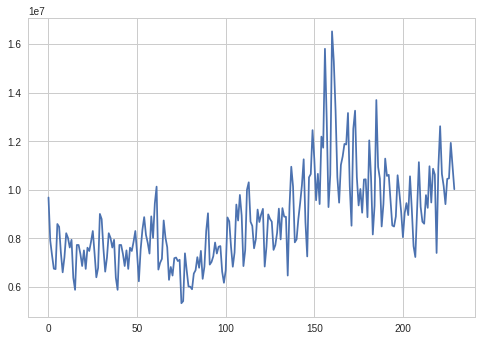

In [ ]:
preds_future = get_pred(X_train[1:], model)


# 시각화
n_future = 230
forecast_period_dates = pd.date_range('2021-01-01', periods=n_future, freq='1d').tolist()
# forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
df_pred['QUANT'] = preds_future

plt.plot(df_pred['QUANT'])

## # LSTM 사용
---

### # 온도
---

In [ ]:
from tensorflow.keras.losses import Huber

df_weather[['TEMP']].info()

training_data, scaler = preprocess(df_weather[['TEMP']].values)
X_train, y_train, X_test = make_dataset_one(training_data, t = 365, h = 1, p = 365)
# X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, shuffle = False, test_size = 0.2, random_state = 0)

unit = 128
output = 1

# The GRU architecture
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=unit, return_sequences=True, activation='tanh', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
    
# # Third GRU layer
model.add(GRU(units=unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))

# Fourth GRU layer
model.add(GRU(units=unit, activation='tanh'))

# The output layer
model.add(Dense(units=output))

# Compiling the RNN
model.compile(optimizer='adam',
              loss=Huber(),
              metrics = ['mae'])

early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Fitting to the training set
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    validation_split = 0.2,
                    batch_size= 25,
                    # callbacks = [early_stop],
                    verbose=1)

# 예측값 
# preds = get_pred(X_test_temp, model)
preds = get_pred(X_test, model)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3044 entries, 2014-01-01 to 2022-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    3044 non-null   float64
dtypes: float64(1)
memory usage: 112.1 KB
Epoch 1/50
86/86 [==============================] - 12s 75ms/step - loss: 0.0083 - mae: 0.0852 - val_loss: 0.0035 - val_mae: 0.0667
Epoch 2/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0025 - mae: 0.0555 - val_loss: 0.0032 - val_mae: 0.0628
Epoch 3/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0024 - mae: 0.0542 - val_loss: 0.0031 - val_mae: 0.0583
Epoch 4/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0021 - mae: 0.0504 - val_loss: 0.0025 - val_mae: 0.0526
Epoch 5/50
86/86 [==============================] - 5s 60ms/step - loss: 0.0020 - mae: 0.0494 - val_loss: 0.0024 - val_mae: 0.0534
Epoch 6/50
86/86 [==============================] - 5s 61ms/step - 

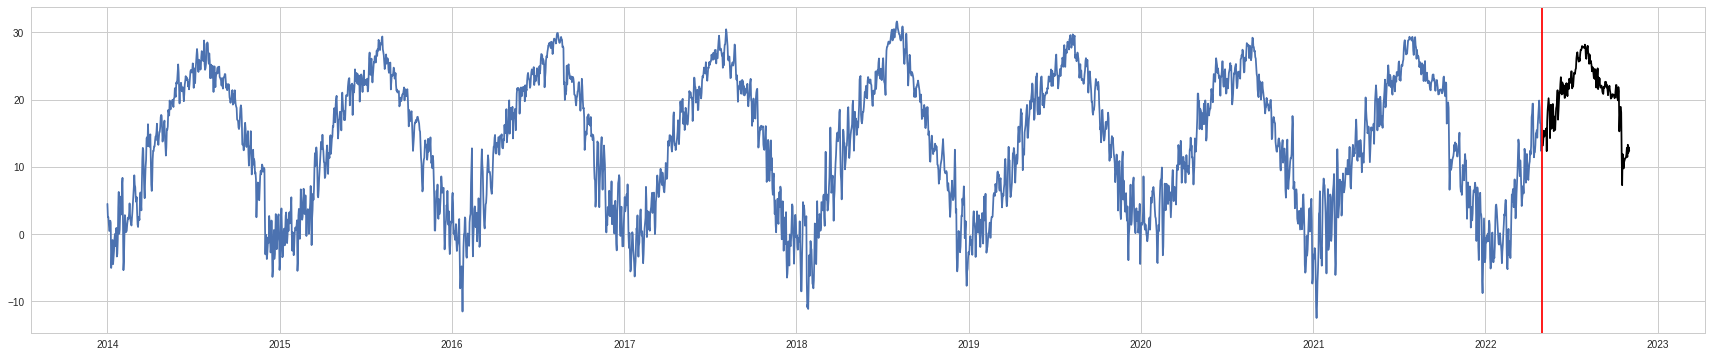

mae : 0.9149885872135993
mse : 0.9966665351332875
rmse : 0.9983318762482182
r2_score : 0.9574789722191643


In [ ]:
# 시각화
n_future = X_test.shape[0]
forecast_period_dates = pd.date_range('2022-05-03', periods=n_future, freq='1d').tolist()
# forecast_period_dates = pd.date_range('2022-01-01', '2022-03-05', freq='1d').tolist()

df_pred = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])
df_pred['SOLDDATE'] = df_pred['SOLDDATE'].astype('datetime64')
df_pred['QUANT'] = preds

import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(30,6))
plt.plot(df_weather['TEMP'])
plt.plot(df_pred.set_index('SOLDDATE'), color = 'black')
plt.axvline(df_weather.index[-1], color='r')
plt.show()

# 모델 평가
d = -1
get_score(df_weather['TEMP'][-365+d:-X_test.shape[0] + (X_test.shape[0] - (365-X_test.shape[0]))+d], preds)

### # 습도
---

### # 강수량
---

### # 신적설량
---

# # 실제 데이터에 변수 붙이기
---

In [ ]:
## # 

In [ ]:
def concat_all(df,weather_data):
    import pandas as pd
    
    # weather_data 병합
    weather_data.SOLDDATE = weather_data.SOLDDATE.astype('str')
    
    # 온도, 습도 표준화 작업
    weather_data.iloc[:, -2:] = MinMaxScaler().fit_transform(weather_data.iloc[:, -2:])
    
    df['SOLDDATE'] = df['SOLDDATE'].astype('str')
    df = df.merge(weather_data, how = 'inner', on = ['SOLDDATE', 'REGION_U'])
    
#     # 건축허가, 건축착공 면적 병합
#     df_permission = get_permission('building_permission')
#     df_construction = get_construction('building_construction')
    
    # 건축착공 면적 표준화 작업
    df_construction = get_construction('building_construction')
    df_construction.iloc[:, -2:] = MinMaxScaler().fit_transform(df_construction.iloc[:, -2:].values)
    
    df['CONSTRUCTION'] = 0
    df['CONSTRUCTION_RATE'] = 0
    df.SOLDDATE = df.SOLDDATE.astype('datetime64')
    for i in df.index:
        year = df.loc[i,'SOLDDATE'].year
        month = df.loc[i,'SOLDDATE'].month

        df.loc[i,'CONSTRUCTION'] = df_construction[(df_construction['YEAR'] == year) & (df_construction['MONTH'] == month)].CONSTRUCTION.values[0]
        df.loc[i,'CONSTRUCTION_RATE'] = df_construction[(df_construction['YEAR'] == year) & (df_construction['MONTH'] == month)].CONSTRUCTION_RATE.values[0]

    df = df[['SOLDDATE', 'CUSTID', 'PRODNAME', 'PRODCODE', 'REGION_U', 'TEMP_M', 'HUM_M', 'CONSTRUCTION', 'CONSTRUCTION_RATE','QUANT']]
    
    return df

df_21_re = concat_all(df_21,weather_21)